In [1]:
!pip install Lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.0 MB/s eta 0:00:00


In [2]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import os
import datetime
import squarify
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline
palette = 'Set2'

# Analysis Approach:
1. RFM 
2. Cohort Analysis
3. Customer LTV

# EDA

# Data Definitions

* InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product code that consists 5 digits.
* Description: Product name.
* Quantity: The quantities of each product per transaction.
* InvoiceDate: Represents the day and time when each transaction was generated.
* UnitPrice: Product price per unit.
* CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
* Country: Name of the country where each customer resides.

In [3]:
ecommerce_path = '/kaggle/input/ecommerce-data/'

df = pd.read_csv(os.path.join(ecommerce_path, 'data.csv'),
                 header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'], 
                 infer_datetime_format = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Customer can order multiple items with the same Invoice Date/Invoice No.

In [4]:
#Data Integrity Check
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
#Number of duplicated items
df.duplicated().sum() 

5268

In [6]:
df['CustomerID'].isnull().sum()/df.shape[0] * 100

24.926694334288598

A quarter of CustomerID has nulls. Yikes.

In [7]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

Where do most of our customer reside? 

In [8]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

Looks like customers are spread across major countries in most continents: North and South America, Europe, Australia. However, presence in Asia could be more.

In [9]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


There are outliers. Negative values in Quantity and UnitPrice reflect cancelled orders. There are also missing value in Description and CustomerID. 

Next step would be:
1. take out NULL values
1. only keep non-cancelled orders and item quantities greater than 0
1. after taking out outliers, reband quantiles
1. multiply Quantity and UnitPrice to get total spent per order

In [10]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()
    
    #Missing Values
    df_ = df_.dropna()
    
    #Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]
    
    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    
    return df_

In [11]:
df = ecommerce_preprocess(df)
df.describe()

,Quantity,UnitPrice,TotalPrice
count,397924.000000,397924.000000,397924.000000
mean,11.833736,2.893163,20.627751
std,25.534512,3.227059,51.826400
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,298.500000,37.060000,3268.575000


# RFM (Recency, Frequency, Monetary)

RFM is a good first pass to see what sort of breakdown is possible across whole user base. If it is too crude, can make come up with more user behavior metrics.

Recency help us judge customers' retention/engagement whereas Frequency and Monetary help us judge their lifetime value.

In [12]:
#Get the max date in order to determine which date to subtract from when determining Recency grades
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
today_date = dt.datetime(2011,12,11)
today_date

datetime.datetime(2011, 12, 11, 0, 0)

In [14]:
#at customer level aggregates
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

rfm = rfm.loc[rfm['monetary'] > 0] #only want customers who spend more than $0
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


# RFM Scores

In [15]:
rfm2 = rfm.copy()
rfm2['recency_score'] = pd.qcut(rfm2['recency'],5,labels = [5, 4, 3, 2, 1])
rfm2

,CustomerID,recency,frequency,monetary,recency_score
0,12346,326,1,310.44,1
1,12347,3,7,4310.00,5
2,12348,76,4,1770.78,2
3,12349,19,1,1491.72,4
4,12350,311,1,331.46,1
...,...,...,...,...,...
4333,18280,278,1,180.60,1
4334,18281,181,1,80.82,1
4335,18282,8,2,178.05,5
4336,18283,4,16,2094.88,5


In [16]:
#For now, we are only combining R and F. Monetary will not be included in overall RFM score. 5 is highest ranking.
def get_rfm_scores(dataframe):
    
    df_ = dataframe.copy()
    df_['recency_score'] = pd.qcut(df_['recency'],5,labels = [5, 4, 3, 2, 1])
    df_['frequency_score'] = pd.qcut(df_['frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    df_['monetary_score'] = pd.qcut(df_['monetary'], 5, labels = [1, 2, 3, 4, 5])
    df_['RFM_SCORE'] = (df_['recency_score'].astype(str) + df_['frequency_score'].astype(str))
    
    return df_

rfm = get_rfm_scores(rfm)

# Segmentation

In [17]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


# Segmentation Map

In [18]:
rfm.segment.value_counts(normalize=True)

hibernating            0.246888
loyal_customers        0.188797
champions              0.145920
at_Risk                0.136699
potential_loyalists    0.111572
about_to_sleep         0.081143
need_attention         0.043107
promising              0.021669
cant_loose             0.014523
new_customers          0.009682
Name: segment, dtype: float64

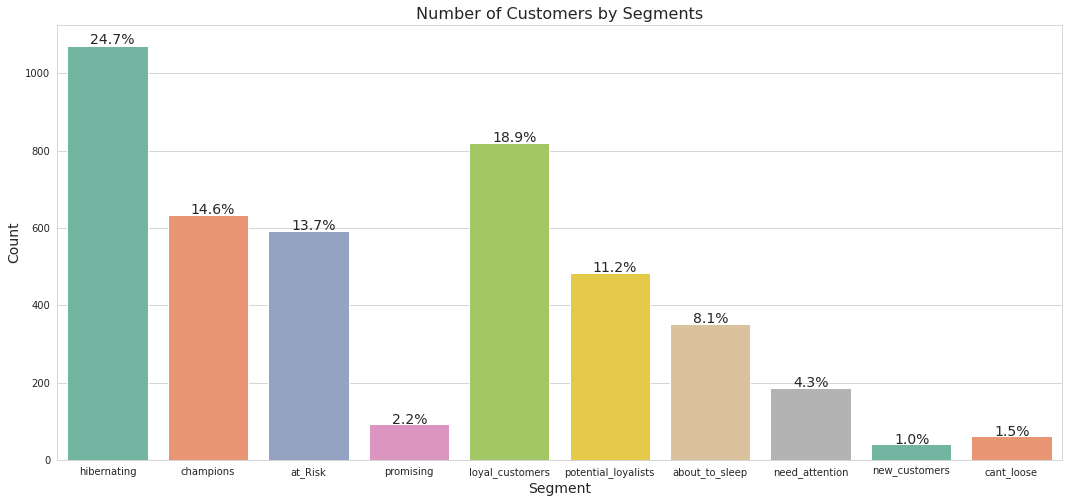

In [19]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

We can easily see from this percentage break down that top 3 of the user base is hibernating, loyal customers or champions. This is optimistic since it shows that even though many customers are dormant there are a bunch that are activity engaging.

# RFM Segments' Distribution

In [20]:
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

recency                           monetary          \
                           std min  max        mean           std     min   
segment                                                                     
about_to_sleep       10.943474  34   72   53.312500    533.161343    6.20   
at_Risk              68.618828  73  374  153.785835    943.170824   52.00   
cant_loose           65.250378  73  373  132.968254   2008.352354   70.02   
champions             3.683300   1   13    6.361769  18366.105822  198.23   
hibernating          92.013560  73  374  217.605042    553.714975    3.75   
loyal_customers      15.577050  15   72   33.608059   5405.787839   36.56   
need_attention       11.552074  34   72   52.427807    732.298552    6.90   
new_customers         3.902112   1   13    7.428571    174.620952   89.94   
potential_loyalists   9.338808   1   33   17.398760    601.746293   20.80   
promising             5.192519  15   33   23.510638    223.634736   30.00   

                                              frequency                      
                            max         mean        std min  max       mean  
segment                                                                      
about_to_sleep         6207.670   469.058097   0.368913   1    2   1.161932  
at_Risk               11072.670   938.458341   0.954415   2    6   2.878583  
cant_loose            10254.180  2646.822540   4.289630   6   34   8.380952  
champions            266163.525  6498.612978  16.476484   3  210  12.417062  
hibernating            9182.345   398.573036   0.302492   1    2   1.101774  
loyal_customers      120210.355  2752.519574   4.545669   3   63   6.479853  
need_attention         4353.830   847.657086   0.470081   2    3   2.326203  
new_customers           848.550   314.883690   0.000000   1    1   1.000000  
potential_loyalists    4628.750   674.628357   0.651401   1    3   2.010331  
promising              1491.720   285.623723   0.000000   1    1   1.000000

Based on the customer segment, we can see where each segment stands with respect to recency, frequency and monetary. We can see that the champions and loyal customers have the highest monetary and frequency values within their distribution.

# Cohort Analysis

A cohort is a group of customers that share the same customer qualities, such as acquisition channel, registration of app, first purchase date. Retention lowers in percentage across periods because customers churn over time. And there are less customers at the beginning of a cohort because takes time for customers to grow in a certain cohort group. In the below analysis, we break up groups based on order date.

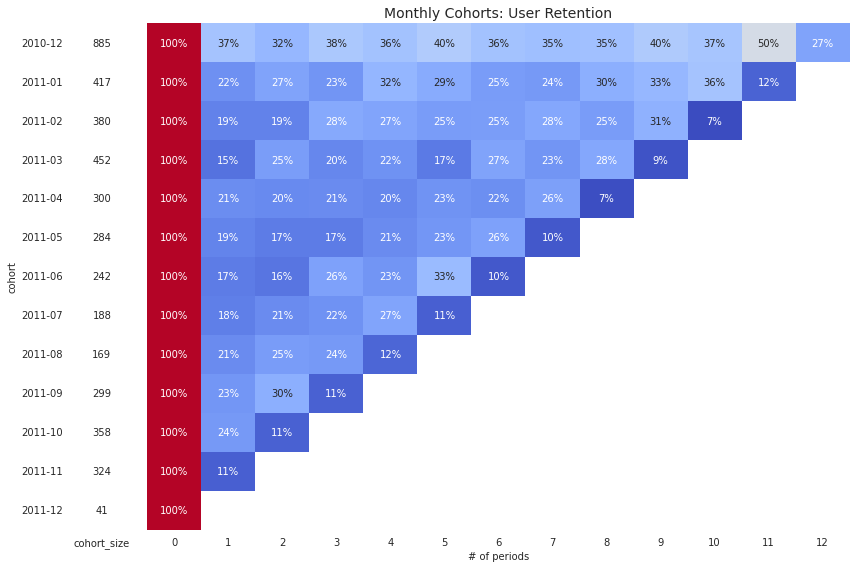

In [21]:
def CohortAnalysis(dataframe):
    
    data = dataframe.copy()
    data = data[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
    data['order_month'] = data['InvoiceDate'].dt.to_period('M')
    data['cohort'] = data.groupby('CustomerID')['InvoiceDate']\
    .transform('min').dt.to_period('M')
    cohort_data = data.groupby(['cohort', 'order_month'])\
    .agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
    cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort)\
    .apply(attrgetter('n'))
    cohort_pivot = cohort_data.pivot_table(index = 'cohort',
                                           columns = 'period_number',
                                           values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8),
                        sharey=True,
                        gridspec_kw={'width_ratios': [1, 11]})
        sns.heatmap(retention_matrix, 
                    mask = retention_matrix.isnull(), 
                    annot = True,
                    cbar = False,
                    fmt='.0%', 
                    cmap='coolwarm', ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=14)
        ax[1].set(xlabel='# of periods',
                  ylabel='')
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'}), 
                    annot=True, 
                    cbar = False,
                    fmt='g',
                    cmap=white_cmap,
                    ax=ax[0])
        fig.tight_layout()
    
CohortAnalysis(df)

The ideal type of cohort analysis is based on broader scope of event data where there are more qualities to describe a customer and therefore have more distinct groups. 

# Customer Lifetime Value
The amount of revenue a customer will bring during its lifetime as a customer.

In [22]:
cltv_df = df.groupby('CustomerID').agg({'InvoiceDate': [lambda x: (x.max() - x.min()).days,
                                                        lambda x: (today_date - x.min()).days], 
                                        'InvoiceNo': 'nunique',
                                        'TotalPrice': 'sum'})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346,0,326,1,310.44
12347,365,368,7,4310.00
12348,282,359,4,1770.78
12349,0,19,1,1491.72
12350,0,311,1,331.46


In [23]:
#Average Order Value
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

#Recency & Tenure
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

# Beta Geometric / Negative Binomial Distribution (BG/NBD) Model

Beta Geometric / Negative Binomial Distribution models assume that the number of transactions made by each customer follows a Poisson process with a heterogeneity in transaction rates across customers following a gamma distribution. These assumptions give us a Negative binomial distribution (NBD) for modeling the number of transactions made by the customer while he is alive. We can build BG/NBD model by using BetaGeoFitter and lifetimes packages.

In [24]:
BGF = BetaGeoFitter(penalizer_coef = 0.001) #avoid overfitting

BGF.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

# Top 10 Expected Number of Transaction (1 Week)

In [25]:
BGF.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']
                                                       ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index() 

,CustomerID,Expected Number of Transactions
0,12748,3.265158
1,14911,3.126645
2,17841,1.940290
3,13089,1.537528
4,14606,1.463999
5,15311,1.433717
6,12971,1.357024
7,14646,1.222517
8,13408,0.986249
9,18102,0.968607


# Top 10 Expected Number of Transaction (1 Month)

In [26]:
BGF.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']
                                                       ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index()

,CustomerID,Expected Number of Transactions
0,12748,13.025670
1,14911,12.473095
2,17841,7.740345
3,13089,6.133456
4,14606,5.840269
5,15311,5.719467
6,12971,5.413481
7,14646,4.876360
8,13408,3.934373
9,18102,3.863856
